<div style="color:white; background-color:#263b52; text-align:center; padding: 25px 0;">
    <div style="font-size:34px; font-family:calibri; font-weight:bold;">
        ML Zoomcamp 2025
    </div>
    <div style="font-size:22px; font-family:verdana; line-height: 1.5; margin-top:10px;">
        Homework 3: Machine Learning for Classification
    </div>
</div>

<div style="margin-top:20px; overflow:auto;">
  <div style="float:left; width:50%; text-align:left; font-family:verdana; font-size:16px; color:#263b52;">
      <p style="margin:4px 0;"><b>Author:</b> CGD</p>
      <p style="margin:4px 0;"><b>GitHub:</b> <a href="https://github.com/CGD2401" target="_blank">CGD2401</a></p>
      <p style="margin:4px 0;"><b>Date:</b> October 2025</p>
  </div>

  <div style="float:right; width:50%; text-align:right; font-family:verdana; font-size:16px; color:#263b52;">
      <p style="margin:4px 0;">Notebook prepared for</p>
      <p style="margin:4px 0;"><b>Machine Learning Zoomcamp</b></p>
      <p style="margin:4px 0;">Homework covering Q1–Q6</p>
  </div>
</div>

<div style="width:100%; clear:both;"></div>

<hr style="border:3px solid #7ba5b0; margin-top:25px;"/>


## 1. Importing libraries

In this section, we load the essential Python libraries required for the homework. 

In [1]:
import os
import warnings
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mutual_info_score

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

pd.set_option("display.max_columns", 100)


## 2. Data loading


Dataset link from the homework:


```
https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
```


In [2]:
DATA_URL = os.environ.get(
    "MLZ_HW3_DATA_URL",
    "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
)

def load_data(src: str) -> pd.DataFrame:
    if src.startswith("http"):
        try:
            df = pd.read_csv(src)
            print(f"Loaded remote CSV: {src}")
            return df
        except Exception as e:
            print(f"Remote load failed: {e}")
            print("If you're offline, download the file manually and set DATA_URL to its local path.")
    # Local fallback
    if Path(src).exists():
        df = pd.read_csv(src)
        print(f"Loaded local CSV: {src}")
        return df
    raise FileNotFoundError(f"Could not load data from {src}.")

df = load_data(DATA_URL)
df.head()

Loaded remote CSV: https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## 3. Data preparation


- Ensure lowercase snake_case column names
"
- Replace missing values as required:
"
  - **Categorical** → `'NA'`
"
  - **Numerical** → `0.0`
"
- Target is `converted` (binary).
"


In [3]:
# Normalize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Identify columns by dtype
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number, "float", "int"]).columns.tolist()

# Convert obvious numeric cols that might be read as object
possible_num = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score", "converted"]
for c in possible_num:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Recompute dtypes after coercion
cat_cols = [c for c in df.columns if df[c].dtype == "object"]
num_cols = [c for c in df.columns if c not in cat_cols]

# Missing values handling
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip()
    df[c] = df[c].fillna("NA").replace({"nan": "NA", "": "NA"})

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

# Ensure target int
if "converted" in df.columns:
    df["converted"] = df["converted"].astype(int)

df[cat_cols + [c for c in ["number_of_courses_viewed","annual_income","interaction_count","lead_score","converted"] if c in df.columns]].head()

,lead_source,industry,employment_status,location,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
0,paid_ads,NA,unemployed,south_america,1,79450.0,4,0.94,1
1,social_media,retail,employed,south_america,1,46992.0,1,0.80,0
2,events,healthcare,unemployed,australia,5,78796.0,3,0.69,1
3,paid_ads,retail,NA,australia,2,83843.0,1,0.87,0
4,referral,education,self_employed,europe,3,85012.0,3,0.62,1


## 4. Homework Questions

### Q1 — Mode for `industry`

In [4]:
q1_mode = df["industry"].mode(dropna=False)[0] if "industry" in df.columns else "NA"
q1_mode

'retail'

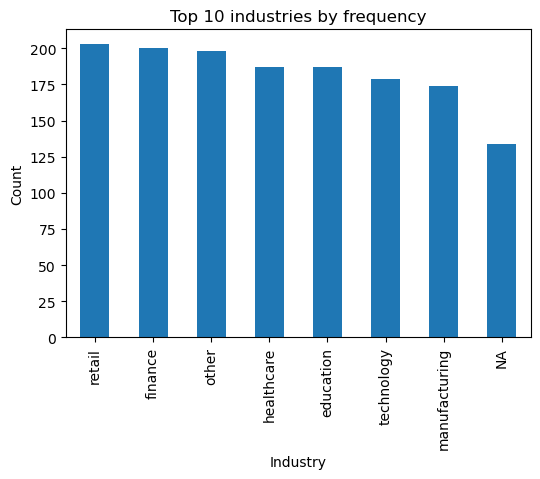

In [5]:
import matplotlib.pyplot as plt

df['industry'].value_counts().head(10).plot(kind='bar', figsize=(6,4))
plt.title("Top 10 industries by frequency")
plt.ylabel("Count")
plt.xlabel("Industry")
plt.show()

### Q2 — Biggest correlation

In [6]:
def pair_corr(a: str, b: str) -> float:
    s = df[[a, b]].copy()
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    return s[a].corr(s[b]) if len(s) > 1 else np.nan

pairs = [
    ("interaction_count", "lead_score"),
    ("number_of_courses_viewed", "lead_score"),
    ("number_of_courses_viewed", "interaction_count"),
    ("annual_income", "interaction_count"),
]

corrs = {}
for a, b in pairs:
    if a in df.columns and b in df.columns:
        corrs[f"{a} & {b}"] = abs(pair_corr(a, b))
    else:
        corrs[f"{a} & {b}"] = np.nan

sorted_corrs = sorted(corrs.items(), key=lambda kv: (np.nan_to_num(kv[1], nan=-1), kv[0]), reverse=True)
sorted_corrs

[('annual_income & interaction_count', 0.027036472404814257),
 ('number_of_courses_viewed & interaction_count', 0.023565222882888096),
 ('interaction_count & lead_score', 0.009888182496913091),
 ('number_of_courses_viewed & lead_score', 0.004878998354681237)]

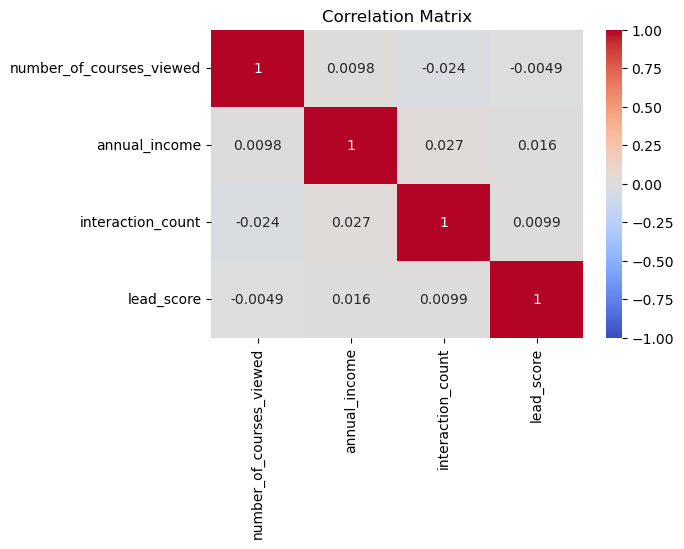

In [7]:
import seaborn as sns

num_features = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]
corr_matrix = df[num_features].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

### Train/Validation/Test split (60/20/20)

In [8]:
# Remove target from features for splitting
if "converted" not in df.columns:
    raise ValueError("Target column 'converted' not found.")

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["converted"])
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=SEED, stratify=df_train_full["converted"])  # 0.25 * 0.8 = 0.2

len(df_train), len(df_val), len(df_test), df['converted'].mean()


(876, 293, 293, 0.6190150478796169)

### Q3 — Biggest MI - Mutual Information (train only)

In [9]:
categorical = ["industry", "location", "lead_source", "employment_status"]
categorical = [c for c in categorical if c in df_train.columns]

def mi_cat(x: pd.Series, y: pd.Series) -> float:
    xi = x.astype("category").cat.codes
    return mutual_info_score(xi, y)

y_train = df_train["converted"]
mi_scores = {}
for c in categorical:
    mi = mi_cat(df_train[c], y_train)
    mi_scores[c] = round(mi, 3)

sorted_mi = sorted(mi_scores.items(), key=lambda kv: kv[1], reverse=True)
sorted_mi


[('lead_source', 0.028),
 ('employment_status', 0.008),
 ('industry', 0.006),
 ('location', 0.001)]

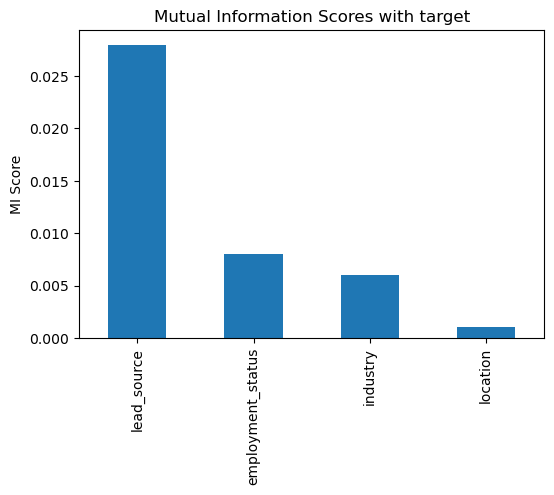

In [10]:
mi_scores_series = pd.Series(mi_scores).sort_values(ascending=False)

mi_scores_series.plot(kind='bar', figsize=(6,4))
plt.title("Mutual Information Scores with target")
plt.ylabel("MI Score")
plt.show()


### Modeling helper

In [11]:
def dict_vectorize(frame: pd.DataFrame, feature_cols: List[str]) -> Tuple[np.ndarray, DictVectorizer]:
    records = frame[feature_cols].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(records)
    return X, dv

def dict_transform(frame: pd.DataFrame, dv: DictVectorizer, feature_cols: List[str]) -> np.ndarray:
    return dv.transform(frame[feature_cols].to_dict(orient="records"))

def train_logreg(train_df: pd.DataFrame, val_df: pd.DataFrame, feature_cols: List[str], C=1.0, solver="liblinear", random_state=42):
    X_train, dv = dict_vectorize(train_df, feature_cols)
    y_train = train_df["converted"].values
    model = LogisticRegression(solver=solver, C=C, max_iter=1000, random_state=random_state)
    model.fit(X_train, y_train)
    X_val = dict_transform(val_df, dv, feature_cols)
    y_val = val_df["converted"].values
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    return acc, model, dv


### Q4 — Baseline model

In [12]:
categorical = ["industry", "location", "lead_source", "employment_status"]
categorical = [c for c in categorical if c in df_train.columns]
numerical = [c for c in ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"] if c in df_train.columns]
feature_cols = categorical + numerical

baseline_acc, baseline_model, baseline_dv = train_logreg(
    df_train, df_val, feature_cols, C=1.0, solver="liblinear", random_state=42
)
round(baseline_acc, 2)


0.73

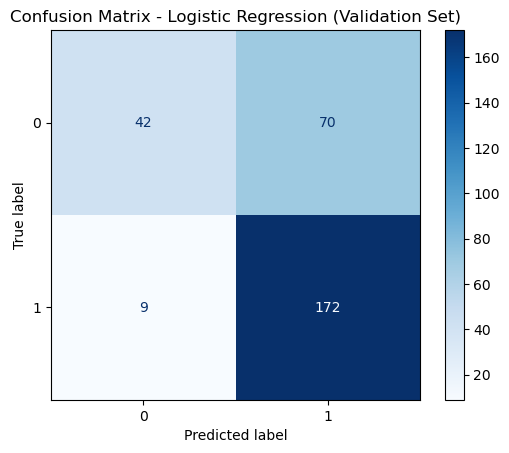

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

y_val = df_val["converted"]
y_pred = baseline_model.predict(dict_transform(df_val, baseline_dv, feature_cols))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (Validation Set)")
plt.show()

### Q5 — Feature selection

In [14]:
# We evaluate removing each candidate feature from the full set and record the accuracy drop
candidates = ["industry", "employment_status", "lead_score"]
candidates = [c for c in candidates if c in feature_cols]

acc_full = baseline_acc  # from Q4
drops = {}

for feat in candidates:
    feats_wo = [f for f in feature_cols if f != feat]
    acc_wo, _, _ = train_logreg(df_train, df_val, feats_wo, C=1.0, solver="liblinear", random_state=42)
    drops[feat] = acc_full - acc_wo

sorted_drops = sorted(drops.items(), key=lambda kv: kv[1])  # smallest difference first
sorted_drops


[('employment_status', -0.0034129692832765013),
 ('industry', 0.0),
 ('lead_score', 0.0)]

### Q6 — Parameter tuning (C)

In [15]:
grid = [0.01, 0.1, 1, 10, 100]
results = []
for C in grid:
    acc, _, _ = train_logreg(df_train, df_val, feature_cols, C=C, solver="liblinear", random_state=42)
    results.append((C, round(acc, 3)))

# Choose the smallest C among the best accuracies
best_acc = max(a for _, a in results)
best_candidates = [C for C, a in results if a == best_acc]
best_C = min(best_candidates)

results, best_C, best_acc


([(0.01, 0.734), (0.1, 0.73), (1, 0.73), (10, 0.73), (100, 0.73)], 0.01, 0.734)

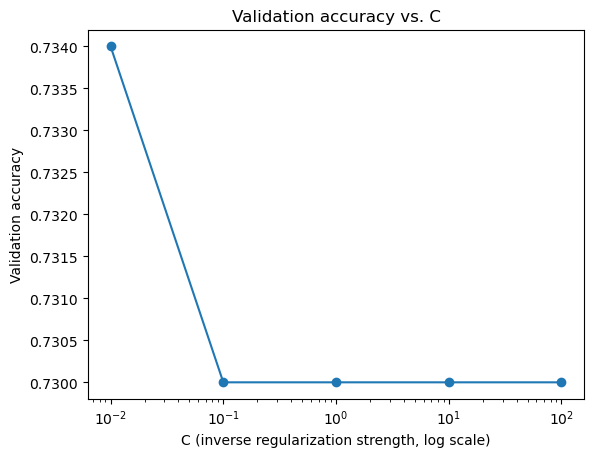

In [16]:
C_values, acc_values = zip(*results)
plt.plot(C_values, acc_values, marker='o')
plt.xscale('log')
plt.xlabel("C (inverse regularization strength, log scale)")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy vs. C")
plt.show()

### Submission — Collect all answers

In [17]:
def pick_option(value, options):
    # For float-like options, compare on formatted strings to desired precision
    try:
        v = float(value)
        # try exact string match after rounding to 2 or 3 decimals depending on options
        if any(opt in ["0.64","0.74","0.84","0.94"] for opt in options):
            vv = f"{round(v,2):.2f}"
        else:
            vv = f"{v:.3f}"
        for opt in options:
            if opt == vv:
                return opt
    except Exception:
        pass
    # string mapping (case-insensitive)
    s = str(value).strip().lower()
    for opt in options:
        if str(opt).strip().lower() == s:
            return opt
    return str(value)

# Q1
q1_opt = ["NA", "technology", "healthcare", "retail"]
Q1 = pick_option(df["industry"].mode(dropna=False)[0], q1_opt)

# Q2
corr_map = {
    "interaction_count & lead_score": "interaction_count and lead_score",
    "number_of_courses_viewed & lead_score": "number_of_courses_viewed and lead_score",
    "number_of_courses_viewed & interaction_count": "number_of_courses_viewed and interaction_count",
    "annual_income & interaction_count": "annual_income and interaction_count"
}
best_pair = sorted_corrs[0][0]
Q2 = corr_map.get(best_pair, best_pair)

# Q3
Q3 = sorted_mi[0][0]  # already rounded in ranking

# Q4
Q4 = pick_option(baseline_acc, ["0.64", "0.74", "0.84", "0.94"])

# Q5
Q5_feat = sorted_drops[0][0] if len(sorted_drops) else "lead_score"
Q5 = f"'{Q5_feat}'"

# Q6
Q6 = pick_option(best_C, ["0.01", "0.1", "1", "10", "100"])

answers = {"Q1": Q1, "Q2": Q2, "Q3": Q3, "Q4": Q4, "Q5": Q5, "Q6": Q6}
answers


{'Q1': 'retail',
 'Q2': 'annual_income and interaction_count',
 'Q3': 'lead_source',
 'Q4': '0.7303754266211604',
 'Q5': "'employment_status'",
 'Q6': '0.01'}

### Appendix — Test set score

In [18]:
# Retrain on train+val with best C and evaluate on the test set
df_tr_full = pd.concat([df_train, df_val], ignore_index=True)
acc_full, model_full, dv_full = train_logreg(df_tr_full, df_test, feature_cols, C=best_C, solver="liblinear", random_state=42)
acc_full

0.7064846416382252